In [2]:
!pip install optuna
!pip install catboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 4.1 MB/s eta 0:00:00


In [33]:
import os
import gc
import time
import warnings
from warnings import simplefilter
from itertools import combinations
import polars as pl

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

warnings.filterwarnings("ignore")
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

from lightgbm import LGBMRegressor,plot_tree
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import optuna
import sklearn as sk
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import train_test_split,StratifiedKFold, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from numba import njit, prange
from catboost import CatBoostRegressor, EShapCalcType, EFeaturesSelectionAlgorithm
from itertools import combinations

In [51]:
#Loading the training and testing Datasets.
df_train = pd.read_csv('train.csv')
#df_train = df_train_origin.sample(200000, random_state = 42)
df_score = pd.read_csv('test.csv')

In [35]:
# Set up parameters
is_offline = False    # Flag for online/offline mode
is_train = True    # Flag for training mode
is_infer = True    # Flag for inference mode
split_day = 435    # Split day for time series data

In [36]:
def reduce_mem_usage(df, verbose=0):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:

                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float32)
    if verbose:
        logger.info(f"Memory usage of dataframe is {start_mem:.2f} MB")
        end_mem = df.memory_usage().sum() / 1024**2
        logger.info(f"Memory usage after optimization is: {end_mem:.2f} MB")
        decrease = 100 * (start_mem - end_mem) / start_mem
        logger.info(f"Decreased by {decrease:.2f}%")
    return df

In [37]:
# Parallel Triplet Imbalance Calculation
@njit(parallel=True)
def compute_triplet_imbalance(df_values, comb_indices):
    num_rows = df_values.shape[0]
    num_combinations = len(comb_indices)
    imbalance_features = np.empty((num_rows, num_combinations))
    for i in prange(num_combinations):
        a, b, c = comb_indices[i]
        for j in range(num_rows):
            max_val = max(df_values[j, a], df_values[j, b], df_values[j, c])
            min_val = min(df_values[j, a], df_values[j, b], df_values[j, c])
            mid_val = df_values[j, a] + df_values[j, b] + df_values[j, c] - min_val - max_val

            if mid_val == min_val:
                imbalance_features[j, i] = np.nan
            else:
                imbalance_features[j, i] = (max_val - mid_val) / (mid_val - min_val)

    return imbalance_features

def calculate_triplet_imbalance_numba(price, df):
    df_values = df[price].values
    comb_indices = [(price.index(a), price.index(b), price.index(c)) for a, b, c in combinations(price, 3)]
    features_array = compute_triplet_imbalance(df_values, comb_indices)
    columns = [f"{a}_{b}_{c}_imb2" for a, b, c in combinations(price, 3)]
    features = pd.DataFrame(features_array, columns=columns)
    return features

In [38]:
weights = [
    0.004, 0.001, 0.002, 0.006, 0.004, 0.004, 0.002, 0.006, 0.006, 0.002, 0.002, 0.008,
    0.006, 0.002, 0.008, 0.006, 0.002, 0.006, 0.004, 0.002, 0.004, 0.001, 0.006, 0.004,
    0.002, 0.002, 0.004, 0.002, 0.004, 0.004, 0.001, 0.001, 0.002, 0.002, 0.006, 0.004,
    0.004, 0.004, 0.006, 0.002, 0.002, 0.04 , 0.002, 0.002, 0.004, 0.04 , 0.002, 0.001,
    0.006, 0.004, 0.004, 0.006, 0.001, 0.004, 0.004, 0.002, 0.006, 0.004, 0.006, 0.004,
    0.006, 0.004, 0.002, 0.001, 0.002, 0.004, 0.002, 0.008, 0.004, 0.004, 0.002, 0.004,
    0.006, 0.002, 0.004, 0.004, 0.002, 0.004, 0.004, 0.004, 0.001, 0.002, 0.002, 0.008,
    0.02 , 0.004, 0.006, 0.002, 0.02 , 0.002, 0.002, 0.006, 0.004, 0.002, 0.001, 0.02,
    0.006, 0.001, 0.002, 0.004, 0.001, 0.002, 0.006, 0.006, 0.004, 0.006, 0.001, 0.002,
    0.004, 0.006, 0.006, 0.001, 0.04 , 0.006, 0.002, 0.004, 0.002, 0.002, 0.006, 0.002,
    0.002, 0.004, 0.006, 0.006, 0.002, 0.002, 0.008, 0.006, 0.004, 0.002, 0.006, 0.002,
    0.004, 0.006, 0.002, 0.004, 0.001, 0.004, 0.002, 0.004, 0.008, 0.006, 0.008, 0.002,
    0.004, 0.002, 0.001, 0.004, 0.004, 0.004, 0.006, 0.008, 0.004, 0.001, 0.001, 0.002,
    0.006, 0.004, 0.001, 0.002, 0.006, 0.004, 0.006, 0.008, 0.002, 0.002, 0.004, 0.002,
    0.04 , 0.002, 0.002, 0.004, 0.002, 0.002, 0.006, 0.02 , 0.004, 0.002, 0.006, 0.02,
    0.001, 0.002, 0.006, 0.004, 0.006, 0.004, 0.004, 0.004, 0.004, 0.002, 0.004, 0.04,
    0.002, 0.008, 0.002, 0.004, 0.001, 0.004, 0.006, 0.004,
]
weights = {int(k):v for k,v in enumerate(weights)}

In [39]:
def imbalance_features(df):
    # Define lists of price and size-related column names
    prices = ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
    sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]

    df["volume"] = df.eval("ask_size + bid_size")
    df["mid_price"] = df.eval("(ask_price + bid_price) / 2")
    df["liquidity_imbalance"] = df.eval("(bid_size-ask_size)/(bid_size+ask_size)")
    df["matched_imbalance"] = df.eval("(imbalance_size-matched_size)/(matched_size+imbalance_size)")
    df["size_imbalance"] = df.eval("bid_size / ask_size")

    for c in combinations(prices, 2):
        df[f"{c[0]}_{c[1]}_imb"] = df.eval(f"({c[0]} - {c[1]})/({c[0]} + {c[1]})")

    for c in [['ask_price', 'bid_price', 'wap', 'reference_price'], sizes]:
        triplet_feature = calculate_triplet_imbalance_numba(c, df)
        df[triplet_feature.columns] = triplet_feature.values

    df["stock_weights"] = df["stock_id"].map(weights)
    df["weighted_wap"] = df["stock_weights"] * df["wap"]
    df['wap_momentum'] = df.groupby('stock_id')['weighted_wap'].pct_change(periods=6)

    df["imbalance_momentum"] = df.groupby(['stock_id'])['imbalance_size'].diff(periods=1) / df['matched_size']
    df["price_spread"] = df["ask_price"] - df["bid_price"]
    df["spread_intensity"] = df.groupby(['stock_id'])['price_spread'].diff()
    df['price_pressure'] = df['imbalance_size'] * (df['ask_price'] - df['bid_price'])
    df['market_urgency'] = df['price_spread'] * df['liquidity_imbalance']
    df['depth_pressure'] = (df['ask_size'] - df['bid_size']) * (df['far_price'] - df['near_price'])

    df['spread_depth_ratio'] = (df['ask_price'] - df['bid_price']) / (df['bid_size'] + df['ask_size'])
    df['mid_price_movement'] = df['mid_price'].diff(periods=5).apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

    df['micro_price'] = ((df['bid_price'] * df['ask_size']) + (df['ask_price'] * df['bid_size'])) / (df['bid_size'] + df['ask_size'])
    df['relative_spread'] = (df['ask_price'] - df['bid_price']) / df['wap']

    # Calculate various statistical aggregation features
    for func in ["mean", "std", "skew", "kurt"]:
        df[f"all_prices_{func}"] = df[prices].agg(func, axis=1)
        df[f"all_sizes_{func}"] = df[sizes].agg(func, axis=1)


    for col in ['matched_size', 'imbalance_size', 'reference_price', 'imbalance_buy_sell_flag']:
        for window in [1,3,5,10]:
            df[f"{col}_shift_{window}"] = df.groupby('stock_id')[col].shift(window)
            df[f"{col}_ret_{window}"] = df.groupby('stock_id')[col].pct_change(window)

    # Calculate diff features for specific columns
    for col in ['ask_price', 'bid_price', 'ask_size', 'bid_size', 'weighted_wap','price_spread']:
        for window in [1,3,5,10]:
            df[f"{col}_diff_{window}"] = df.groupby("stock_id")[col].diff(window)

    #V4 feature
    for window in [3,5,10]:
        df[f'price_change_diff_{window}'] = df[f'bid_price_diff_{window}'] - df[f'ask_price_diff_{window}']
        df[f'size_change_diff_{window}'] = df[f'bid_size_diff_{window}'] - df[f'ask_size_diff_{window}']

    #V5 - rolling diff
    # Convert from pandas to Polars
    pl_df = pl.from_pandas(df)

    #Define the windows and columns for which you want to calculate the rolling statistics
    windows = [3, 5, 10]
    columns = ['ask_price', 'bid_price', 'ask_size', 'bid_size']

    # prepare the operations for each column and window
    group = ["stock_id"]
    expressions = []

    # Loop over each window and column to create the rolling mean and std expressions
    for window in windows:
        for col in columns:
            rolling_mean_expr = (
                pl.col(f"{col}_diff_{window}")
                .rolling_mean(window)
                .over(group)
                .alias(f'rolling_diff_{col}_{window}')
            )

            rolling_std_expr = (
                pl.col(f"{col}_diff_{window}")
                .rolling_std(window)
                .over(group)
                .alias(f'rolling_std_diff_{col}_{window}')
            )

            expressions.append(rolling_mean_expr)
            expressions.append(rolling_std_expr)

    # Run the operations using Polars' lazy API
    lazy_df = pl_df.lazy().with_columns(expressions)

    # Execute the lazy expressions and overwrite the pl_df variable
    pl_df = lazy_df.collect()

    # Convert back to pandas if necessary
    df = pl_df.to_pandas()
    gc.collect()

    df['mid_price*volume'] = df['mid_price_movement'] * df['volume']
    df['harmonic_imbalance'] = df.eval('2 / ((1 / bid_size) + (1 / ask_size))')

    for col in df.columns:
        df[col] = df[col].replace([np.inf, -np.inf], 0)

    return df

def other_features(df):
    df["dow"] = df["date_id"] % 5  # Day of the week
    df["seconds"] = df["seconds_in_bucket"] % 60
    df["minute"] = df["seconds_in_bucket"] // 60
    df['time_to_market_close'] = 540 - df['seconds_in_bucket']

    for key, value in global_stock_id_feats.items():
        df[f"global_{key}"] = df["stock_id"].map(value.to_dict())

    return df

def generate_all_features(df):
    # Select relevant columns for feature generation
    cols = [c for c in df.columns if c not in ["row_id", "time_id"]]
    df = df[cols]

    # Generate imbalance features
    df = imbalance_features(df)
    gc.collect()
    df = other_features(df)
    gc.collect()
    feature_name = [i for i in df.columns if i not in ["row_id", "time_id", "date_id"]]

    return df[feature_name]

In [ ]:
%%time

df_stock = df_train.groupby("stock_id")
global_stock_id_feats = {
    "median_size": df_stock["bid_size"].median() + df_stock["ask_size"].median(),
    "std_size": df_stock["bid_size"].std() + df_stock["ask_size"].std(),
    "ptp_size": df_stock["bid_size"].max() - df_stock["bid_size"].min(),
    "median_price": df_stock["bid_price"].median() + df_stock["ask_price"].median(),
    "std_price": df_stock["bid_price"].std() + df_stock["ask_price"].std(),
    "ptp_price": df_stock["bid_price"].max() - df_stock["ask_price"].min(),
}

df_train = generate_all_features(df_train)
print("Build df_train Finished.")
df_train = reduce_mem_usage(df_train)

feature_name = list(df_train.columns)
print(f"Feature length = {len(feature_name)}")

In [46]:
X_train,X_test, y_train,y_test=train_test_split(df_train.drop('target',axis=1),df_train['target'], test_size=0.2,random_state=42)

print(f"train : {X_train.shape}, test : {X_test.shape}")

gc.collect()

train : (160000, 160), test : (40000, 160)


0

In [47]:
# Fill NA values in both test and train set
for col in X_train.columns.tolist():
  d=X_train[col].dropna().median()
  X_train[col]=X_train[col].fillna(d)
  X_test[col]=X_test[col].fillna(d)
c= y_train.dropna().median()
y_train=y_train.fillna(d)
y_test=y_test.fillna(d)

In [ ]:
len(X_train.columns)

160

In [ ]:
X_train.columns

Index(['stock_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size',
       ...
       'dow', 'seconds', 'minute', 'time_to_market_close',
       'global_median_size', 'global_std_size', 'global_ptp_size',
       'global_median_price', 'global_std_price', 'global_ptp_price'],
      dtype='object', length=160)

In [ ]:
X_test.columns

Index(['stock_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size',
       ...
       'dow', 'seconds', 'minute', 'time_to_market_close',
       'global_median_size', 'global_std_size', 'global_ptp_size',
       'global_median_price', 'global_std_price', 'global_ptp_price'],
      dtype='object', length=160)

<a class="btn btn-warning btn-lg btn-block active" role="button" aria-pressed="true" style="background-color:DodgerBlue; color:white">Data Visualization</a>

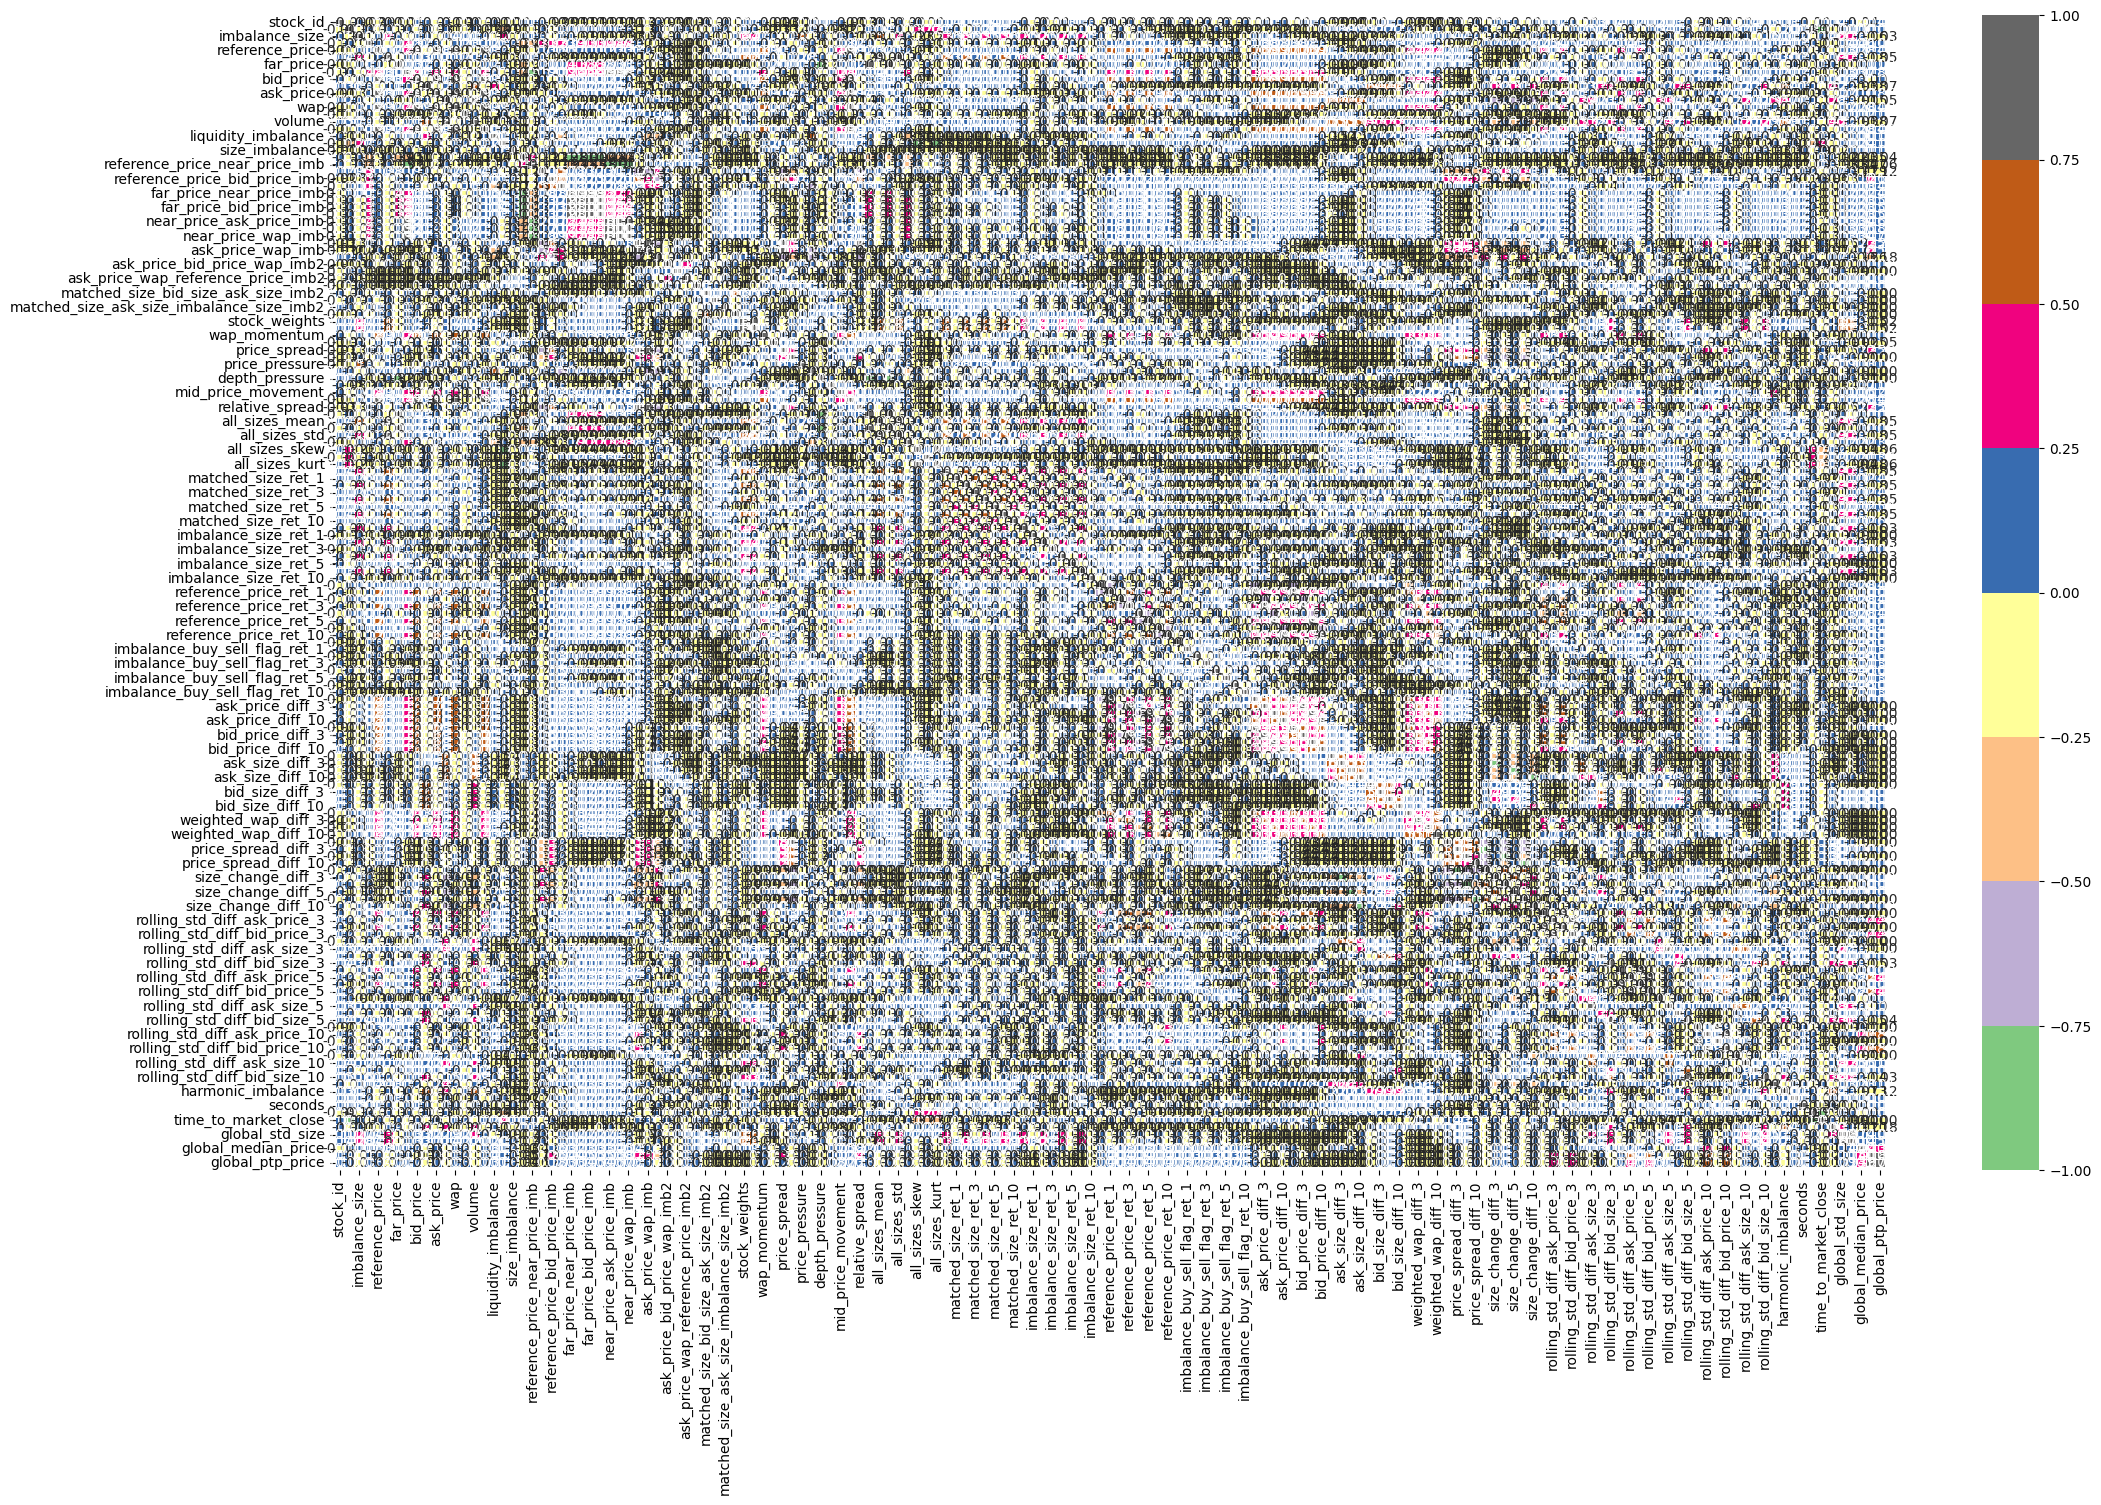

In [ ]:
# Corralation Matrix
corr_matrix = df_train.corr()
fig, ax = plt.subplots(figsize=(25, 15))
ax = sns.heatmap(corr_matrix, annot=True, linewidths=0.5, fmt=".2f", cmap=plt.cm.Accent);
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [ ]:
# # violinplot

# i=1
# plt.figure(figsize=(25,25))
# for col in X_train.columns:
#     plt.subplot(4,6, i) #!!!

#     df=pd.melt(df_train[[col] + ['target']], id_vars="target",
#     var_name="{}".format(""), value_name='{}_Histogram'.format(col))

#     sns.violinplot(x="{}".format(""),y="{}_Histogram".format(col), data=df, hue="target",split=True, inner="quart")
#     i=i+1

### Optuna Optimization

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.datasets import load_wine
import optuna
from optuna.samplers import TPESampler
import catboost
from xgboost import XGBClassifier

In [18]:
#LGBMRegressor mae
def objective(trial):
    params = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "num_leaves": trial.suggest_int("num_leaves", 20, 150),
        "n_estimators": trial.suggest_int('n_estimators', 20, 500),
        "objective": trial.suggest_categorical("objective",['mae']),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
        'subsample': trial.suggest_loguniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 1.0),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.5, 1, step=0.1),
        #"n_jobs":trial.suggest_int("n_jobs",[-1] ),
        "n_jobs":-1,
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
    }
    model = LGBMRegressor(**params)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_test, y_test)],
        eval_metric="mean_absolute_error")

    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    return mae

In [21]:
sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="lightgbm", direction="minimize", sampler=sampler)
study.optimize(objective, n_trials=200)

[I 2024-03-17 23:06:09,571] A new study created in memory with name: lightgbm


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5330484577001838 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5330484577001838 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.216572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36493
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 160
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5330484577001838 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bag

[I 2024-03-17 23:06:41,927] Trial 0 finished with value: 6.259702975901599 and parameters: {'num_leaves': 74, 'n_estimators': 366, 'objective': 'mae', 'learning_rate': 0.010033168697030017, 'max_depth': 6, 'min_child_samples': 11, 'subsample': 0.5330484577001838, 'colsample_bytree': 0.5689052151487055, 'reg_alpha': 0.010881335003635882, 'reg_lambda': 0.015498955191377133, 'bagging_fraction': 0.8, 'bagging_freq': 5}. Best is trial 0 with value: 6.259702975901599.


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=0.6677152068759228 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=0.6677152068759228 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.245048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36493
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 160
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=0.6677152068759228 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value

[I 2024-03-17 23:06:49,989] Trial 1 finished with value: 6.267569135648843 and parameters: {'num_leaves': 109, 'n_estimators': 118, 'objective': 'mae', 'learning_rate': 0.26465405655337415, 'max_depth': 3, 'min_child_samples': 35, 'subsample': 0.6677152068759228, 'colsample_bytree': 0.7364654898283542, 'reg_alpha': 0.00263730777909246, 'reg_lambda': 0.003929203002623947, 'bagging_fraction': 0.9, 'bagging_freq': 10}. Best is trial 0 with value: 6.259702975901599.


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.5137202267368393 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.5137202267368393 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.214321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36493
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 160
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.5137202267368393 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value

[I 2024-03-17 23:07:18,517] Trial 2 finished with value: 6.408736965570307 and parameters: {'num_leaves': 61, 'n_estimators': 353, 'objective': 'mae', 'learning_rate': 0.2641528541658511, 'max_depth': 14, 'min_child_samples': 8, 'subsample': 0.5137202267368393, 'colsample_bytree': 0.562463124180224, 'reg_alpha': 0.43095062042610816, 'reg_lambda': 0.0019726066891840957, 'bagging_fraction': 0.7, 'bagging_freq': 10}. Best is trial 0 with value: 6.259702975901599.


[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=0.5063785774394761 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=0.5063785774394761 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.480434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36493
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 160
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=0.5063785774394761 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bag

[I 2024-03-17 23:07:58,645] Trial 3 finished with value: 6.311452085318327 and parameters: {'num_leaves': 89, 'n_estimators': 352, 'objective': 'mae', 'learning_rate': 0.10149953299175825, 'max_depth': 11, 'min_child_samples': 43, 'subsample': 0.5063785774394761, 'colsample_bytree': 0.8409805355884081, 'reg_alpha': 0.9259408975542383, 'reg_lambda': 0.17558886158773745, 'bagging_fraction': 0.6, 'bagging_freq': 8}. Best is trial 0 with value: 6.259702975901599.


[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=0.5471576868077282 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=0.5471576868077282 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.207935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36493
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 160
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=0.5471576868077282 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bag

[I 2024-03-17 23:08:13,233] Trial 4 finished with value: 6.346505903284074 and parameters: {'num_leaves': 33, 'n_estimators': 235, 'objective': 'mae', 'learning_rate': 0.2734926958969977, 'max_depth': 6, 'min_child_samples': 18, 'subsample': 0.5471576868077282, 'colsample_bytree': 0.5067573303609728, 'reg_alpha': 0.10876936642969391, 'reg_lambda': 0.004314041792135616, 'bagging_fraction': 0.6, 'bagging_freq': 5}. Best is trial 0 with value: 6.259702975901599.


[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=0.5367545529901934 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=0.5367545529901934 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.243599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36493
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 160
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=0.5367545529901934 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bag

[I 2024-03-17 23:08:30,716] Trial 5 finished with value: 6.260900439778403 and parameters: {'num_leaves': 26, 'n_estimators': 296, 'objective': 'mae', 'learning_rate': 0.05255128672268494, 'max_depth': 10, 'min_child_samples': 37, 'subsample': 0.5367545529901934, 'colsample_bytree': 0.6662132663150602, 'reg_alpha': 0.12111570825917506, 'reg_lambda': 0.017479854309911964, 'bagging_fraction': 0.5, 'bagging_freq': 6}. Best is trial 0 with value: 6.259702975901599.


[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=0.5499890131848617 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=0.5499890131848617 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.209091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36493
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 160
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=0.5499890131848617 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value

[I 2024-03-17 23:08:55,038] Trial 6 finished with value: 6.536269103334221 and parameters: {'num_leaves': 106, 'n_estimators': 267, 'objective': 'mae', 'learning_rate': 0.28393247923733583, 'max_depth': 10, 'min_child_samples': 46, 'subsample': 0.5499890131848617, 'colsample_bytree': 0.5506762706110759, 'reg_alpha': 0.26434668351371066, 'reg_lambda': 0.015596620715924285, 'bagging_fraction': 0.5, 'bagging_freq': 10}. Best is trial 0 with value: 6.259702975901599.


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.8414459065004204 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.8414459065004204 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.250934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36493
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 160
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.8414459065004204 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value

[I 2024-03-17 23:09:31,621] Trial 7 finished with value: 6.37740860749359 and parameters: {'num_leaves': 65, 'n_estimators': 381, 'objective': 'mae', 'learning_rate': 0.2205394157516309, 'max_depth': 14, 'min_child_samples': 33, 'subsample': 0.8414459065004204, 'colsample_bytree': 0.6367938650575968, 'reg_alpha': 0.006453327048461239, 'reg_lambda': 0.4871454545414106, 'bagging_fraction': 0.7, 'bagging_freq': 10}. Best is trial 0 with value: 6.259702975901599.


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.7465907888190734 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.7465907888190734 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.247149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36493
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 160
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.7465907888190734 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bag

[I 2024-03-17 23:10:07,248] Trial 8 finished with value: 6.2594597572494015 and parameters: {'num_leaves': 106, 'n_estimators': 319, 'objective': 'mae', 'learning_rate': 0.0432763321564788, 'max_depth': 15, 'min_child_samples': 25, 'subsample': 0.7465907888190734, 'colsample_bytree': 0.6634854819605172, 'reg_alpha': 0.0051413946432500015, 'reg_lambda': 0.5130250385596953, 'bagging_fraction': 0.8, 'bagging_freq': 1}. Best is trial 8 with value: 6.2594597572494015.


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=0.9385692832797695 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=0.9385692832797695 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.585629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36493
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 160
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=0.9385692832797695 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value

[I 2024-03-17 23:10:31,061] Trial 9 finished with value: 6.298828615970956 and parameters: {'num_leaves': 100, 'n_estimators': 177, 'objective': 'mae', 'learning_rate': 0.1628468496547067, 'max_depth': 14, 'min_child_samples': 21, 'subsample': 0.9385692832797695, 'colsample_bytree': 0.7702294097057525, 'reg_alpha': 0.0011154849842472576, 'reg_lambda': 0.6142026716955344, 'bagging_fraction': 0.9, 'bagging_freq': 10}. Best is trial 8 with value: 6.2594597572494015.


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.7202676698930133 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.7202676698930133 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.245694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36493
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 160
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.7202676698930133 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bag

[I 2024-03-17 23:11:39,686] Trial 10 finished with value: 6.302516133782606 and parameters: {'num_leaves': 149, 'n_estimators': 480, 'objective': 'mae', 'learning_rate': 0.12372474726268398, 'max_depth': 12, 'min_child_samples': 25, 'subsample': 0.7202676698930133, 'colsample_bytree': 0.8569939288899191, 'reg_alpha': 0.025824034191819473, 'reg_lambda': 0.09773114544570702, 'bagging_fraction': 1.0, 'bagging_freq': 1}. Best is trial 8 with value: 6.2594597572494015.


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.6552605938257866 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.6552605938257866 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.247609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36493
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 160
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.6552605938257866 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bag

[I 2024-03-17 23:12:28,408] Trial 11 finished with value: 6.255248700899179 and parameters: {'num_leaves': 138, 'n_estimators': 466, 'objective': 'mae', 'learning_rate': 0.011797585887626801, 'max_depth': 7, 'min_child_samples': 5, 'subsample': 0.6552605938257866, 'colsample_bytree': 0.612338845198755, 'reg_alpha': 0.01170777215791925, 'reg_lambda': 0.048885788778883325, 'bagging_fraction': 0.8, 'bagging_freq': 1}. Best is trial 11 with value: 6.255248700899179.


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.673053163947419 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.673053163947419 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.578905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36493
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 160
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.673053163947419 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: baggin

[I 2024-03-17 23:13:42,459] Trial 12 finished with value: 6.256952252222059 and parameters: {'num_leaves': 137, 'n_estimators': 485, 'objective': 'mae', 'learning_rate': 0.028752124806741473, 'max_depth': 7, 'min_child_samples': 5, 'subsample': 0.673053163947419, 'colsample_bytree': 0.9797889329812051, 'reg_alpha': 0.013853897793893122, 'reg_lambda': 0.07667152513710714, 'bagging_fraction': 0.8, 'bagging_freq': 1}. Best is trial 11 with value: 6.255248700899179.


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=0.6428209522977557 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=0.6428209522977557 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.246059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36493
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 160
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=0.6428209522977557 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bag

Exception ignored on calling ctypes callback function: <function _log_callback at 0x79ed5e706170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py", line 203, in _log_callback
    def _log_callback(msg: bytes) -> None:
KeyboardInterrupt: 


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[W 2024-03-17 23:13:57,422] Trial 13 failed with parameters: {'num_leaves': 148, 'n_estimators': 491, 'objective': 'mae', 'learning_rate': 0.013024902198823383, 'max_depth': 6, 'min_child_samples': 5, 'subsample': 0.6428209522977557, 'colsample_bytree': 0.9988052054323502, 'reg_alpha': 0.02722866547223191, 'reg_lambda': 0.0650410730169361, 'bagging_fraction': 0.9, 'bagging_freq': 3} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-18-cb2f090ad5a3>", line 22, in objective
    model.fit(
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py", line 1049, in fit
    super().fit(
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py", line 842, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py", line 276, in train
    bo

KeyboardInterrupt: 

'num_leaves': 146, 'n_estimators': 494, 'objective': 'mae', 'learning_rate': 0.09675713378758799, 'max_depth': 13, 'min_child_samples': 38, 'subsample': 0.8846236833272005, 'colsample_bytree': 0.875635157953628, 'reg_alpha': 0.031598830941276745, 'reg_lambda': 0.26466457985079583, 'bagging_fraction': 1.0, 'bagging_freq': 8

### LGBM Model Train

In [ ]:
# Lightgbm with OPTUNA tuned hyperparameters without undersampling

cv_predictions_lgbm = np.zeros(len(y_train))
test_predictions_lgbm = np.zeros(len(y_test))
#..................................................................................................................
feature_importance_lgbm=pd.DataFrame()
feature_importance_lgbm["features"]=X_train.columns.to_list()
feature_importance_lgbm["importance"]=0
#..................................................................................................................
models=dict()
#..................................................................................................................
i=1
skf = sk.model_selection.TimeSeriesSplit(5).split(X_train, y_train)
for fold, (train_index, test_index) in enumerate(skf):
    param_grid = {

        'num_leaves': 146,
        'n_estimators': 494,
        'objective': 'mae',
        'learning_rate': 0.09675713378758799,
        'max_depth': 13,
        'min_child_samples': 38,
        'subsample': 0.8846236833272005,
        'colsample_bytree': 0.875635157953628,
        'reg_alpha': 0.031598830941276745,
        'reg_lambda': 0.26466457985079583,
        'bagging_fraction': 1.0,
        'bagging_freq': 8
        }

    model = LGBMRegressor(**lgb_params)
    model.fit(X_train.iloc[train_index], y_train.iloc[train_index],
              eval_set=[(X_train.iloc[train_index], y_train.iloc[train_index]), (X_train.iloc[test_index], y_train.iloc[test_index])],
              eval_metric=["mae", "r2"],
              verbose=False)  # Set verbose to True if you want to see the log

    print("---------------------------------------------------------------------------------------------------")
    print("Model LGBM "+str(i)+" :",clf)
    models["Model LGBM "+str(i)]=clf
    print("---------------------------------------------------------------------------------------------------")

    cv_predictions_lgbm[test_index] = model.predict(X_train.iloc[test_index])
    test_predictions_lgbm += model.predict(X_test)/5

    feature_importance_lgbm["importance"]+=model.feature_importances_ /5
    i+=1
#..............................................................................................................
# Calculate Mean Absolute Error (MAE) for the training and test sets
lgbm_mae_train = mean_absolute_error(y_train, cv_predictions_lgbm)
lgbm_mae_test = mean_absolute_error(y_test, test_predictions_lgbm)
#..............................................................................................................
print("LGBM's MAE CV Score:> ", round(lgbm_mae_train, 3))
print("LGBM's MAE Test Score:> ", round(lgbm_mae_test, 3))
print("-------------------------------------------------------------------------------------------------------")

In [32]:
# Lightgbm with OPTUNA tuned hyperparameters without undersampling

cv_predictions_lgbm = np.zeros(len(y_train))
test_predictions_lgbm = np.zeros(len(y_test))
#..................................................................................................................
feature_importance_lgbm=pd.DataFrame()
feature_importance_lgbm["features"]=X_train.columns.to_list()
feature_importance_lgbm["importance"]=0
#..................................................................................................................
models=dict()
#..................................................................................................................
i=1
skf = sk.model_selection.TimeSeriesSplit(5).split(X_train, y_train)
for fold, (train_index, test_index) in enumerate(skf):
    param_grid = {
        "learning_rate":[0.1],
        "boosting_type":['gbdt'],
        "num_leaves":[31],
        "max_depth":[-1],
        "n_estimators":[100],
        "subsample_for_bin":[2000000],
        "objective":['mae'],
        "class_weight":[None],
        "min_split_gain" :[0],
        "min_child_weight" :[0.001],
        "min_child_samples" :[20],
        "subsample":[1.0],
        "colsample_bytree":[1.0],
        "reg_alpha":[0.0],
        "reg_lambda":[0.0],
        #"random_state":[SEED],
        "n_jobs":[-1],
        "importance_type":['split'],
        "force_row_wise":[True],
        }

    Grid_lgb= HalvingGridSearchCV(LGBMRegressor(n_jobs=-1),scoring ="neg_mean_absolute_error",param_grid=param_grid,
        refit=True,n_jobs = -1)


    Grid_lgb.fit(X_train.iloc[train_index], y_train.iloc[train_index],
                 eval_set=[(X_train.iloc[train_index],y_train.iloc[train_index]),(X_train.iloc[test_index],y_train.iloc[test_index])],
            eval_metric=["neg_mean_absolute_error", "r2"])


    clf=Grid_lgb.best_estimator_
    print("---------------------------------------------------------------------------------------------------")
    print("Model LGBM "+str(i)+" :",clf)
    models["Model LGBM "+str(i)]=clf
    print("---------------------------------------------------------------------------------------------------")

    cv_predictions_lgbm[test_index] = clf.predict(X_train.iloc[test_index])
    test_predictions_lgbm+= clf.predict(X_test)/5

    feature_importance_lgbm["importance"]+=clf.feature_importances_ /5
    i+=1
#..............................................................................................................
# Calculate Mean Absolute Error (MAE) for the training and test sets
lgbm_mae_train = mean_absolute_error(y_train, cv_predictions_lgbm)
lgbm_mae_test = mean_absolute_error(y_test, test_predictions_lgbm)
#..............................................................................................................
print("LGBM's MAE CV Score:> ", round(lgbm_mae_train, 3))
print("LGBM's MAE Test Score:> ", round(lgbm_mae_test, 3))
print("-------------------------------------------------------------------------------------------------------")


[LightGBM] [Info] Total Bins 36492
[LightGBM] [Info] Number of data points in the train set: 26670, number of used features: 160
[LightGBM] [Info] Start training from score -0.020266
---------------------------------------------------------------------------------------------------
Model LGBM 1 : LGBMRegressor(force_row_wise=True, min_split_gain=0, n_jobs=-1, objective='mae',
              subsample_for_bin=2000000)
---------------------------------------------------------------------------------------------------
[LightGBM] [Info] Total Bins 36492
[LightGBM] [Info] Number of data points in the train set: 53336, number of used features: 160
[LightGBM] [Info] Start training from score -0.060201
---------------------------------------------------------------------------------------------------
Model LGBM 2 : LGBMRegressor(force_row_wise=True, min_split_gain=0, n_jobs=-1, objective='mae',
              subsample_for_bin=2000000)
------------------------------------------------------------

In [48]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error

# Define CatBoost Regressor
model = LGBMRegressor(
        num_leaves = 146,
        n_estimators = 494,
        objective = 'mae',
        learning_rate = 0.09675713378758799,
        max_depth = 13,
        min_child_samples = 38,
        subsample = 0.8846236833272005,
        colsample_bytree = 0.875635157953628,
        reg_alpha = 0.031598830941276745,
        reg_lambda = 0.26466457985079583,
        bagging_fraction = 1.0,
        bagging_freq = 8
)

# Fit model
model.fit(X_train, y_train,
              eval_set= (X_train, y_train),
              eval_metric=["mae"])


# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error on validation set: {mae}')

[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.8846236833272005 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.8846236833272005 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.258463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36490
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 160
[LightGBM] [Info] Start training from score -0.060201
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bag

In [ ]:
# LGBM's MAE CV Score:>  5.203
# LGBM's MAE Test Score:>  5.209

In [ ]:
plt.figure(figsize=(13,10))
y=feature_importance_lgbm.sort_values(by="importance",ascending=False)["importance"][:40].values
x=[c for c in feature_importance_lgbm.sort_values(by="importance",ascending=False)["features"][:40].values]
sns.barplot(x=y,y=x)
plt.title("lgbm’s Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()